# Multitaper and Hamonic Ftest


In [1]:
from scipy.signal import lfilter
import math
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

from src.multitaper import MultiTaper_Periodogram #適宜変更
from src.multitaper import get_data #適宜変更

Load sediment core data
Number of points and dt  156 4930


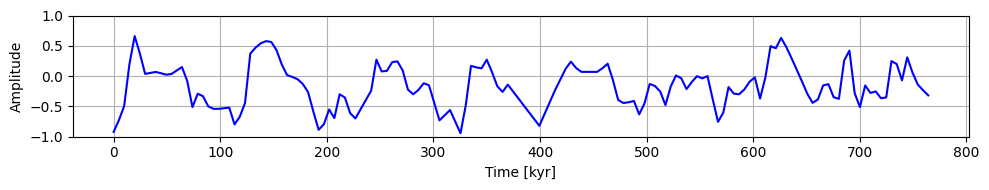

self.k_DPS, self.eigenvalues,self.Jk, self.Smt_k, self.Smt, f


C:\Users\chamu\AppData\Local\Temp\ipykernel_39468\349266007.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,1e5)


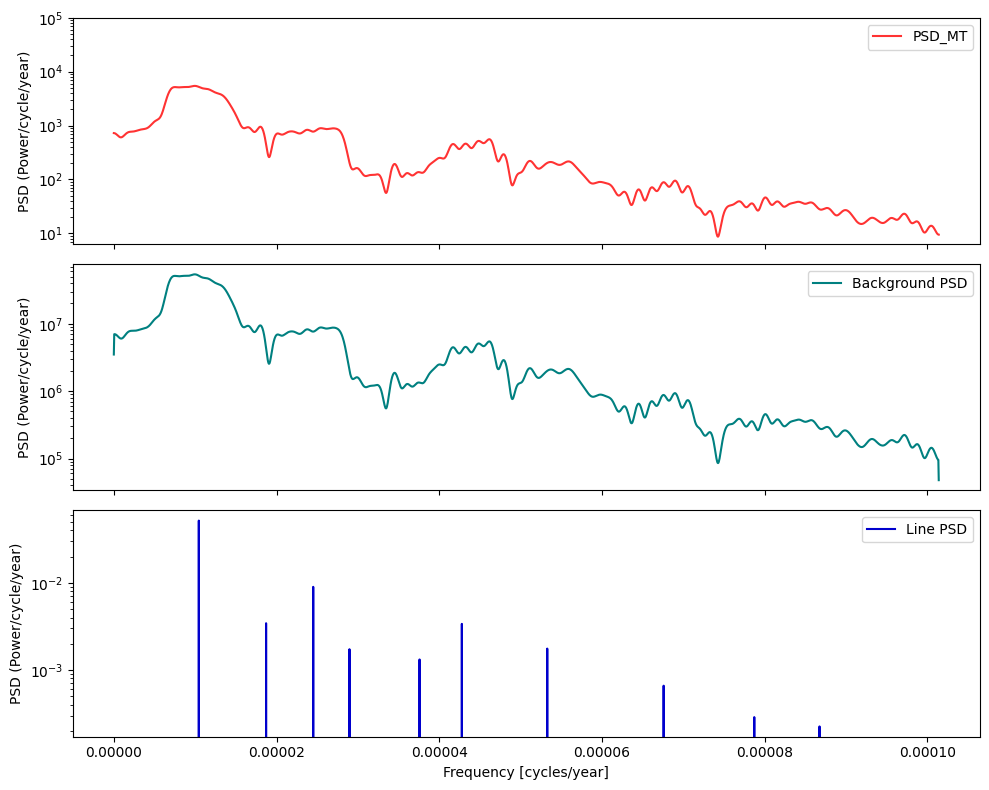

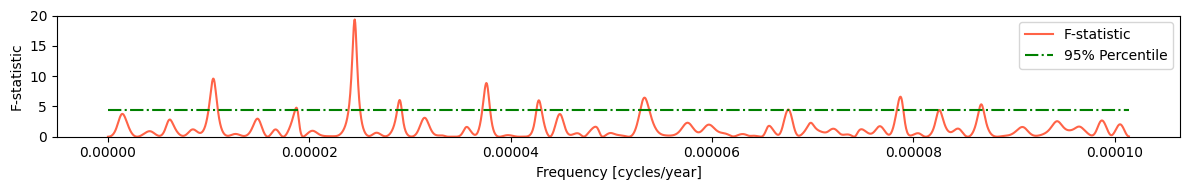

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# データ読み込みと時間軸生成
x = get_data('v22_174_series.dat')
npts = np.shape(x)[0]
dt   = 4930  # サンプリング間隔 [years]
t    = np.arange(npts) * dt
print('Load sediment core data')
print('Number of points and dt ', npts, dt)

# 元信号のプロット
fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot()
ax.plot(t / 1e3, x, label="AM Signal", color='b')
ax.set_xlabel("Time [kyr]")   # ← 単位を「千年」に修正
ax.set_ylabel("Amplitude")
ax.set_ylim(-1.0,1.0)
ax.grid()
plt.tight_layout()
plt.show()

# サンプリング周波数 [cycles/year]
fs = 1.0 / dt

# マルチターパーPSD推定とF検定
MT_psd = MultiTaper_Periodogram(NW=3.5, K=5, nfft=2**12)
MT_psd.MT_Spec(x, fs)                 # ← fs = 1/dt を渡す
MT_psd.Harmonic_Ftest(p_level=0.05)


# PSDと再構成スペクトルのプロット
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# ① PSD_MTと再構成PSD
ax = axes[0]
ax.plot(MT_psd.f, MT_psd.Smt, '-', label='PSD_MT', alpha=0.8, c='r', lw=1.5)
ax.set_ylabel('PSD (Power/cycle/year)')
ax.set_yscale("log")
# ax.set_xlim(0, 0.1)  # 例: 周波数範囲を cycles/year に合わせて調整
ax.set_ylim(0,1e5)
ax.legend()

# ② バックスペクトル（線成分除去後）
ax = axes[1]
ax.plot(MT_psd.f, MT_psd.re_psd[0, :], '-', label='Background PSD', alpha=1, c='teal', lw=1.5)
ax.set_ylabel('PSD (Power/cycle/year)')
ax.set_yscale("log")
ax.legend()

# ③ 線成分スペクトルのみ
ax = axes[2]
ax.plot(MT_psd.f, MT_psd.re_psd[2, :], '-', label='Line PSD', alpha=1, c='mediumblue', lw=1.5)
ax.set_ylabel('PSD (Power/cycle/year)')
ax.set_xlabel('Frequency [cycles/year]')
ax.set_yscale("log")
ax.legend()

fig.tight_layout()
plt.show()

# F統計量のプロット
fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
ax.plot(MT_psd.f, MT_psd.F_stat[0, :], '-', label='F-statistic', alpha=1, c='tomato', lw=1.5)
ax.hlines(MT_psd.F_crit, MT_psd.f[0], MT_psd.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlabel('Frequency [cycles/year]')
# ax.set_xlim(0, 0.1)  # 周波数範囲を cycles/year に合わせて調整
ax.set_ylim(0, 20)
ax.legend()
fig.tight_layout()
plt.show()


Create MTSPEC class for your data
Type of psd  <class 'multitaper.mtspec.MTSpec'>
[10.34526268]


C:\Users\chamu\AppData\Local\Temp\ipykernel_39468\4001175409.py:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


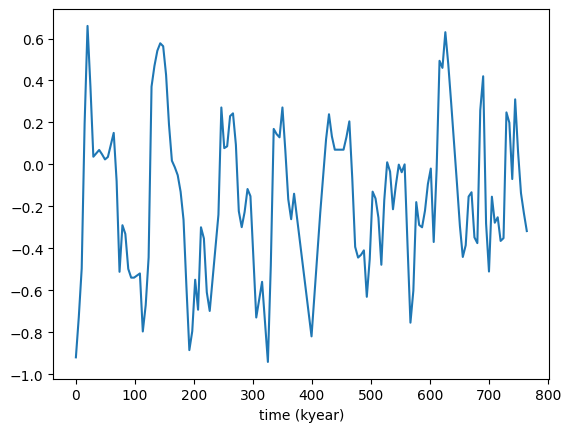

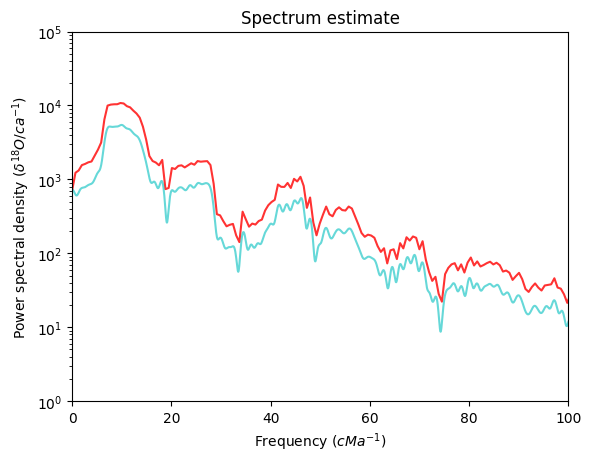

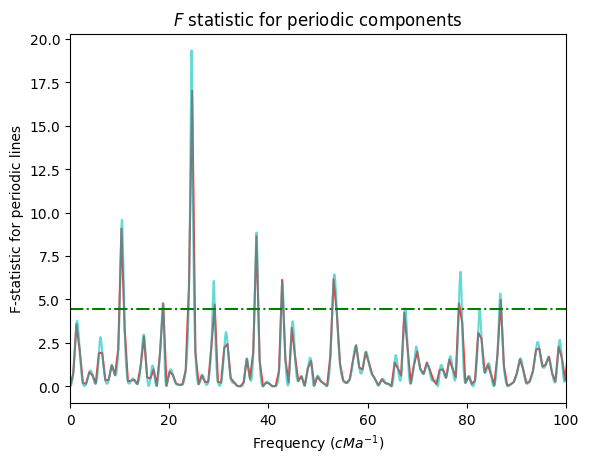

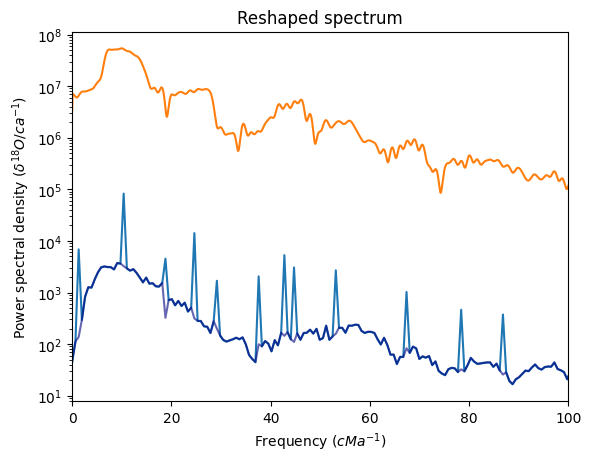

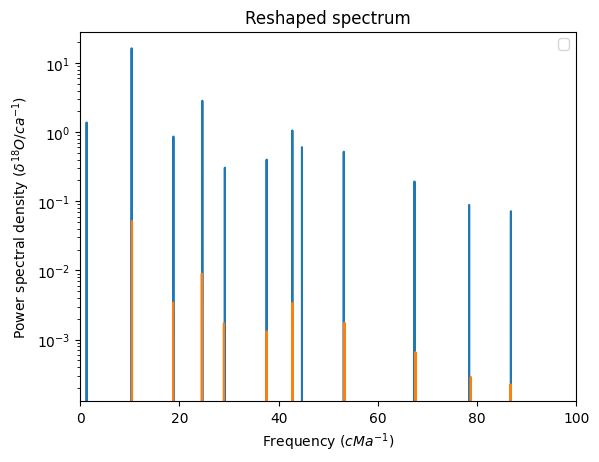

In [ ]:
from multitaper import MTSpec, MTCross, MTSine, SineCross
import multitaper.utils as utils

# Define desired parameters
#------------------------------------------------
nw    = 3.5
kspec = 5 

fig = plt.figure(1)
ax  = fig.add_subplot()
ax.plot(t/1000,x)
ax.set_xlabel('time (kyear)')

#------------------------------------------------
# Get MTSPEC
#     Get reshape spectrum with F test
#     Get confidence intervals
#     Get QI spectrum
#------------------------------------------------

print('Create MTSPEC class for your data')
psd = MTSpec(x,nw,kspec,dt,iadapt=1, nfft=2^14)
print('Type of psd ', type(psd))

#------------------------------------------------
# Reshape spectrum
#------------------------------------------------
F,p = psd.ftest()
respec, spec_noline, yk, sline = psd.reshape(fcrit=0.90,p=p)
#------------------------------------------------
# Confidence intervals
#------------------------------------------------
# spec_ci = psd.jackspec()
#------------------------------------------------
# QI inverse spectrum
#------------------------------------------------
# qispec  = psd.qiinv()[0]

# Plot only positive frequencies
freq ,spec               = psd.rspec()
# freq,qispec,spec_ci      = psd.rspec(qispec,spec_ci)
k_yk = np.mean(np.abs(yk)**2, axis=1)[:,np.newaxis]

freq,respec,spec_noline,sline,k_yk  = psd.rspec(respec,spec_noline,sline,k_yk)

F = F[0:psd.nf]

fig = plt.figure(2)
ax  = fig.add_subplot()
ax.semilogy(freq*1e6,spec, 'r',alpha=0.8, label="lib")
ax.semilogy(MT_psd.f*1e6, MT_psd.Smt, 'c',alpha=0.6,label="My")
# ax.semilogy(freq*1e6,spec_ci,'k--')
# ax.semilogy(freq*1e6,qispec,'r--')
ax.set_title('Spectrum estimate')
ax.set_xlim(0, 100)
ax.set_ylim(1,1e5)
ax.set_xlabel(r'Frequency ($c Ma^{-1}$)')
ax.set_ylabel(r'Power spectral density ($\delta^{18}O/ca^{-1}$)')

fig = plt.figure(3)
ax  = fig.add_subplot()
ax.plot(freq*1e6,F, 'r',alpha=0.8)
ax.plot(MT_psd.f*1e6, MT_psd.F_stat[0, :], 'c',alpha=0.6)
ax.hlines(MT_psd.F_crit, MT_psd.f[0]*1e6, MT_psd.f[-1]*1e6, linestyles="-.", color='green', label='95% Percentile')

ax.set_xlim(0,100)
ax.set_title(r'$F$ statistic for periodic components')
ax.set_xlabel(r'Frequency ($c Ma^{-1}$)')
ax.set_ylabel(r'F-statistic for periodic lines')
#plt.ylim(-0.5,14.5)

fig = plt.figure(4)
ax  = fig.add_subplot()
ax.semilogy(freq*1e6,respec)
ax.semilogy(MT_psd.f*1e6, MT_psd.re_psd[1,:])
ax.semilogy(freq*1e6, k_yk*dt, 'navy',alpha=0.6)
ax.set_xlim(0,100)
ax.set_title(r'Reshaped spectrum')
ax.set_xlabel(r'Frequency ($c Ma^{-1}$)')
ax.set_ylabel(r'Power spectral density ($\delta^{18}O/ca^{-1}$)')
#plt.ylim(-0.5,14.5)
fig = plt.figure(5)
ax  = fig.add_subplot()
ax.semilogy(freq*1e6,sline)
ax.semilogy(MT_psd.f*1e6, MT_psd.re_psd[2,:])
ax.set_xlim(0,100)
ax.set_title(r'Reshaped spectrum')
ax.set_xlabel(r'Frequency ($c Ma^{-1}$)')
ax.set_ylabel(r'Power spectral density ($\delta^{18}O/ca^{-1}$)')
ax.legend()
plt.show()

## AR4

## 減衰信号

power = 61.35275848459341


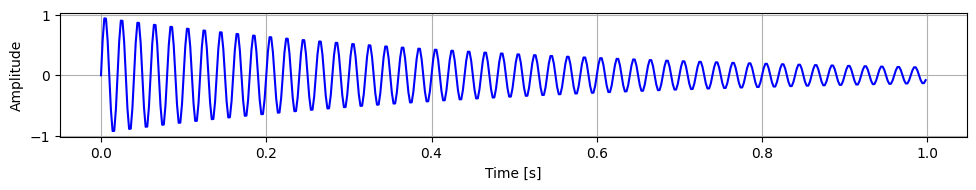

self.k_DPS, self.eigenvalues,self.Jk, self.Smt_k, self.Smt, f


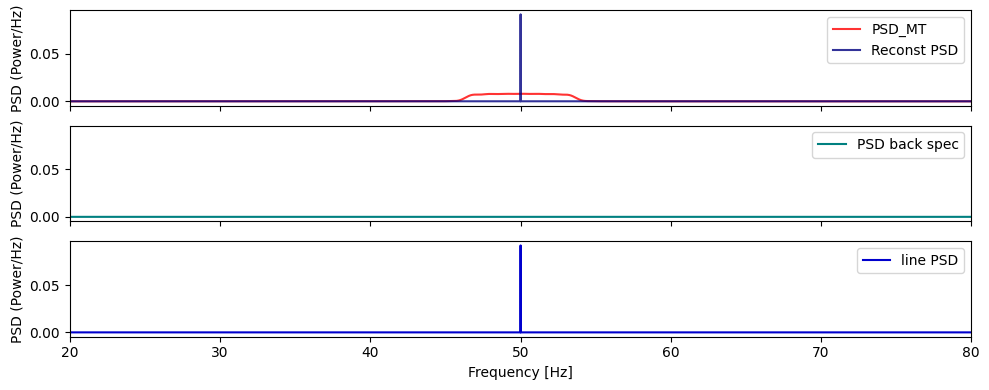

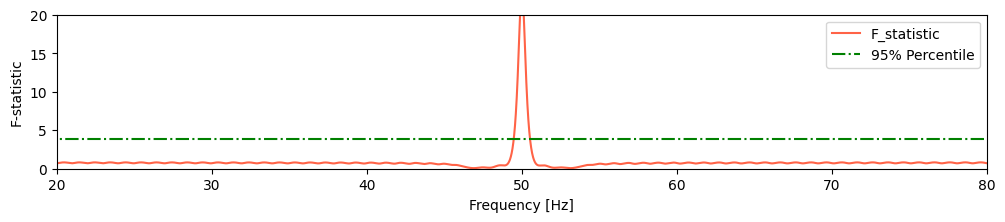

In [11]:

# パラメータ設定
fs_e = 500  # サンプリング周波数 (Hz)
t = np.linspace(0, 1, fs_e, endpoint=False)  # 時間軸（1秒間分のデータ）

f = 50  # 振動の周波数 (Hz)
decay_rate = 2  # 減衰率（大きいほど早く減衰）

# 減衰振動の生成
amplitude = np.exp(-decay_rate * t)  # 減衰を表す指数関数
oscillation = np.sin(2 * np.pi * f * t)  # 正弦波
# oscillation = np.clip(oscillation, -0.6, 0.6)
am_signal = amplitude * oscillation  # 減衰振動

print(f'power = {np.sum(np.abs(am_signal)**2)/1}')


# noisy_am_signal = am_signal
# プロット
fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot()
ax.plot(t, am_signal, label="AM Signal", color='b')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.grid()
plt.tight_layout()
plt.show()


MTSpec = MultiTaper_Periodogram(NW=4,nfft=2**16)
MTSpec.MT_Spec(am_signal, fs_e)
MTSpec.Harmonic_Ftest(p_level=0.05)

fig, axes = plt.subplots(3, 1, figsize=(10, 4),sharex=True, sharey=True)  # 3行1列のサブプロット

# ---- プロット (PSD_MT，Reconstructed PS) ----
ax = axes[0]
ax.plot(MTSpec.f, MTSpec.Smt, '-', label='PSD_MT', alpha=0.8, c='r', lw=1.5)
ax.plot(MTSpec.f, MTSpec.re_psd[1, :], '-', label='Reconst PSD', alpha=0.8, c='navy', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
# ax.set_yscale("log")
ax.set_xlim(20,80)
ax.legend()

# ---- プロット (Backpectrum PSD) ----
ax = axes[1]
ax.plot(MTSpec.f, MTSpec.re_psd[0, :], '-', label='PSD back spec', alpha=1, c='teal', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
ax.legend()
# ---- プロット (Spectrum Line PSD) ----
ax = axes[2]
ax.plot(MTSpec.f, MTSpec.re_psd[2, :], '-', label='line PSD', alpha=1, c='mediumblue', lw=1.5)
ax.set_ylabel('PSD (Power/Hz)')
ax.set_xlabel('Frequency [Hz]')
ax.legend()
# ---- レイアウトの調整 ----
plt.tight_layout()  # 各プロットの間隔を調整
plt.show()


# ---- プロット (F-statistic) ----
fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
ax.plot(MTSpec.f, MTSpec.F_stat[0, :], '-', label='F_statistic', alpha=1, c='tomato', lw=1.5)
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F-statistic')
ax.set_xlabel('Frequency [Hz]')
ax.set_xlim(20,80)
ax.set_ylim(0,20)
ax.legend()




## DPSS 

0th 0.9999999997060941
1th 0.9999999723687615
2th 0.9999987916126629
3th 0.9999675893000647
4th 0.9994105128955671
5th 0.9925078649626218
6th 0.9366654986606355


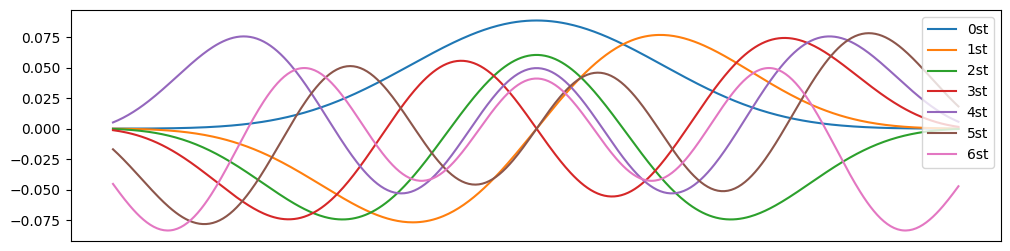

nw:4, N:500, W:4.0


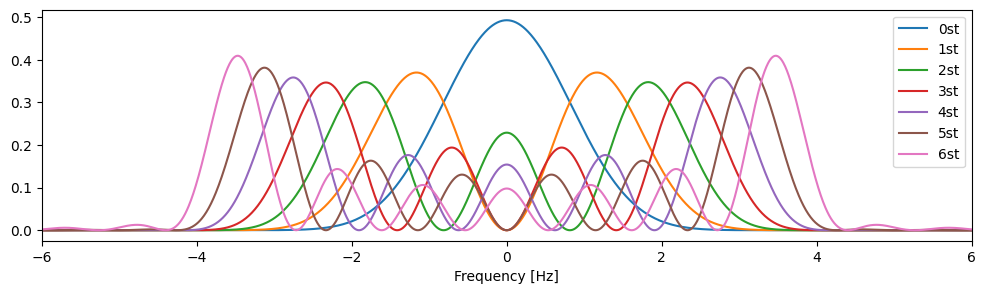

In [12]:
plt.figure(figsize=(12, 3))

for k_i in range(MTSpec.K):
    # k_i 番目のターパー
    plt.plot(MTSpec.k_DPSS[k_i, :], label=f'{k_i}st') 
    print(f"{k_i}th {MTSpec.eigenvalues[k_i]}")

plt.xticks([])
# plt.grid()
plt.legend(loc='upper right')
plt.show()


# FFT の計算
H_k = np.fft.fft(MTSpec.k_DPSS, n=MTSpec.nfft, axis=1)
H_k_PSD = (1 / MTSpec.fs) * np.abs(H_k)**2  

# 周波数軸を対応させる
freqs = np.fft.fftfreq(MTSpec.nfft, d=1/MTSpec.fs)  

# fftshift を適用
H_k_PSD_shifted = np.fft.fftshift(H_k_PSD, axes=1)  # 周波数成分をシフト
freqs_shifted = np.fft.fftshift(freqs)  # 周波数軸もシフト

print(f"nw:{MTSpec.NW}, N:{MTSpec.N}, W:{MTSpec.NW / MTSpec.N * MTSpec.fs}")

# プロット
plt.figure(figsize=(12, 3))
for k_i in range(MTSpec.K):
    plt.plot(freqs_shifted, H_k_PSD_shifted[k_i, :], label=f'{k_i}st') 

# 軸の範囲を適切に設定
plt.xlim(-MTSpec.NW / MTSpec.N * MTSpec.fs * 1.5, MTSpec.NW / MTSpec.N * MTSpec.fs * 1.5)
# plt.yscale("log")
plt.xlabel("Frequency [Hz]")
plt.legend(loc='upper right')
plt.show()

,Time:512Hz,Epoch,FP1,FP2,F7,Fz,F8,T3,C3,Cz,C4,T4,T5,Pz,T6,O1,O2,Event Id,Event Date,Event Duration
0,0.000000,7840,29068.474609,16043.802734,66537.117188,48942.300781,46747.140625,37714.492188,41452.582031,46752.359375,39487.441406,36383.238281,29403.966797,64742.707031,48880.750000,48013.484375,50548.804688,NaN,NaN,NaN
1,0.001953,7840,28882.087891,15877.711914,66265.804688,48685.671875,46661.941406,37437.453125,41160.683594,46473.718750,39199.546875,36090.765625,29135.296875,64464.402344,48601.859375,47746.492188,50276.796875,NaN,NaN,NaN
2,0.003906,7840,28480.357422,15619.443359,65925.687500,48465.843750,46358.433594,37192.238281,40900.492188,46222.437500,38959.296875,35792.894531,28879.283203,64208.078125,48338.355469,47476.367188,50000.710938,NaN,NaN,NaN
3,0.005859,7840,28442.494141,15361.359375,65869.085938,48370.648438,46011.203125,37144.343750,40838.093750,46162.632812,38914.601562,35716.761719,28817.134766,64145.109375,48262.589844,47398.531250,49921.441406,NaN,NaN,NaN
4,0.007812,7840,28484.421875,15680.270508,66102.539062,48491.339844,46259.292969,37318.671875,41024.398438,46339.375000,39082.535156,35938.675781,28998.343750,64328.062500,48468.093750,47584.843750,50107.140625,NaN,NaN,NaN


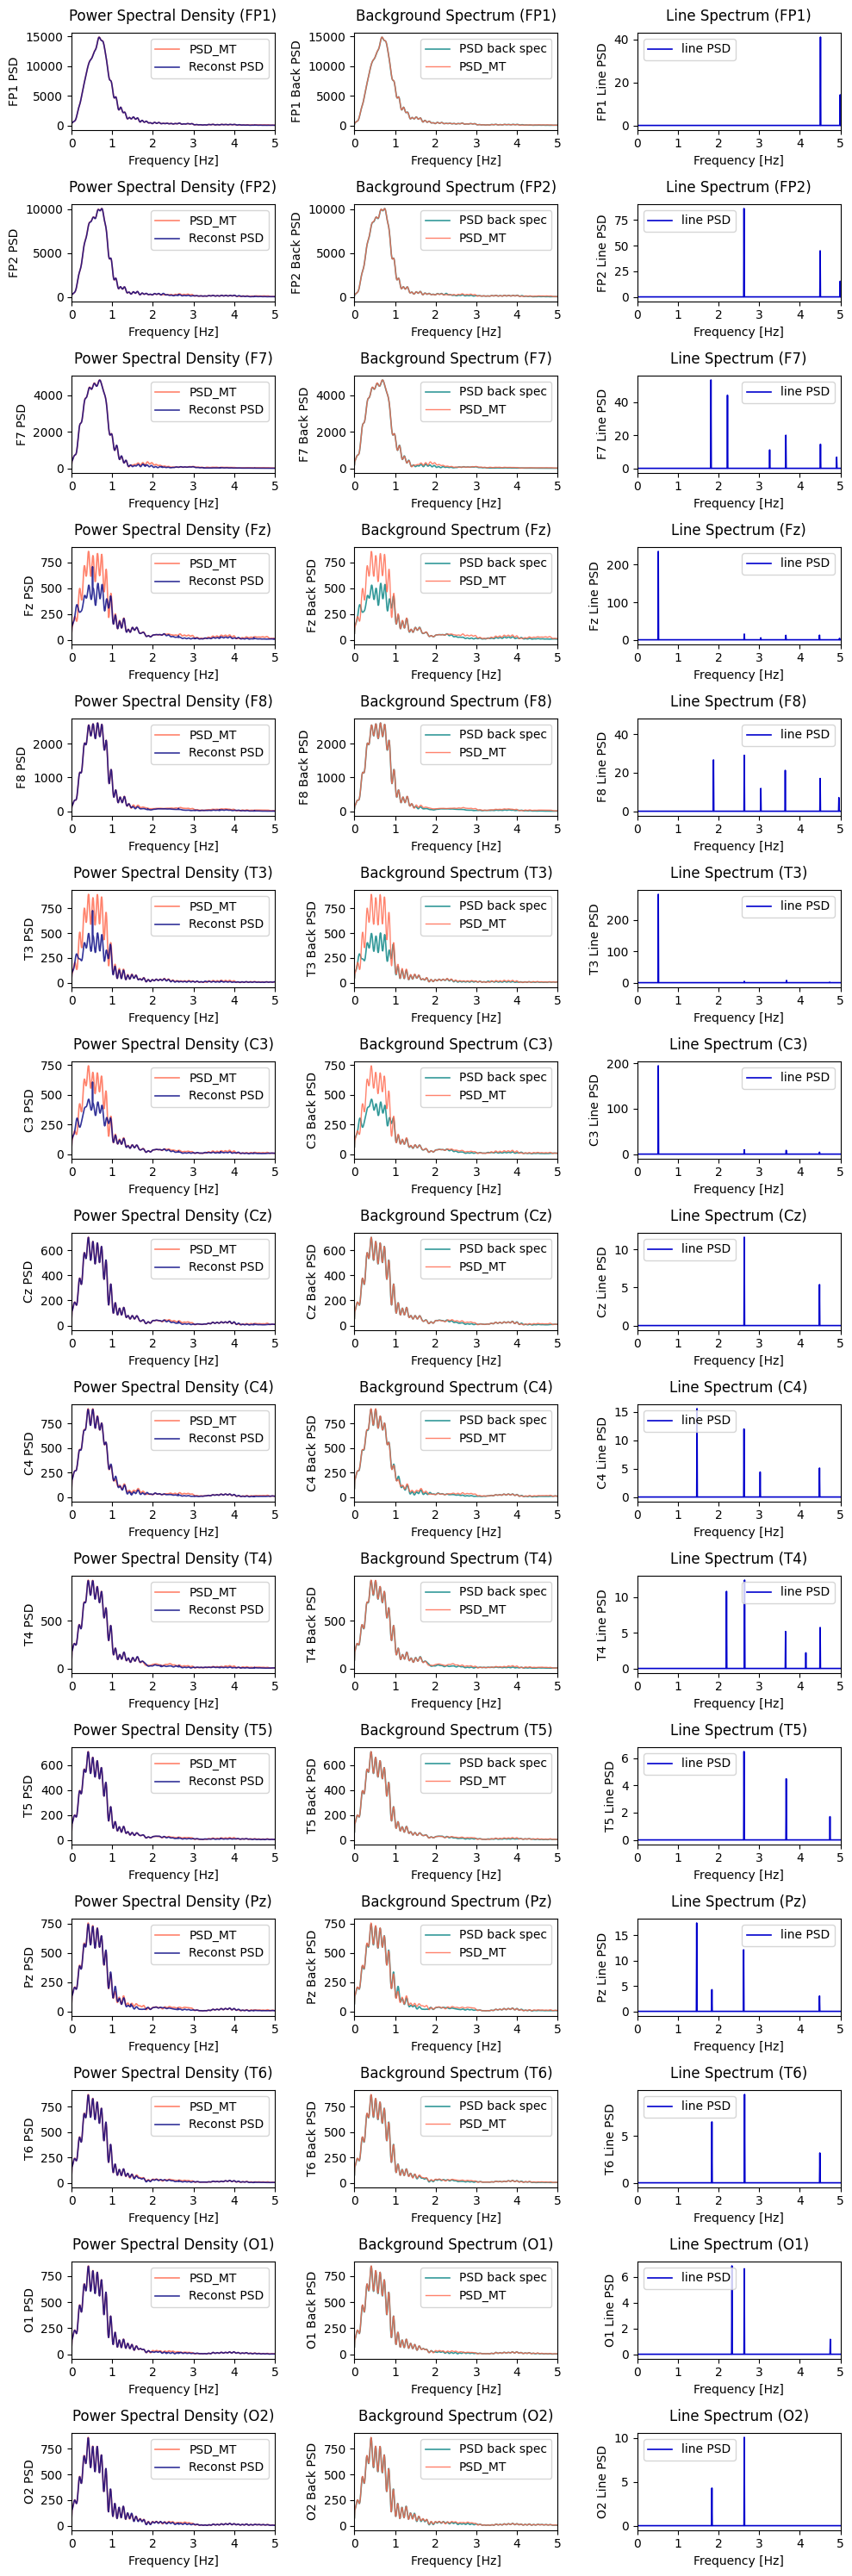

In [ ]:

df = pd.read_csv(rf".\test_data\EEG_sample.csv")
display(df.head())

fs_EEG =512
time_EEG = df["Time:512Hz"].to_numpy()
EEG_channels = df.columns[2:-3]

def lowpass(x, samplerate, cutoff, gpass, gstop):
    fn = samplerate / 2                           # ナイキスト周波数
    wp = cutoff / fn                              # 通過域端周波数（正規化）
    ws = (cutoff * 0.5) / fn                      # 阻止域端周波数（正規化、少し低めに設定）
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  
    b, a = signal.butter(N, Wn, btype="low")     
    y = signal.filtfilt(b, a, x)                  
    return y                                      
def highpass(x, samplerate, cutoff, gpass, gstop):
    fn = samplerate / 2                           # ナイキスト周波数
    wp = cutoff / fn                              # 通過域端周波数（正規化）
    ws = (cutoff * 0.5) / fn                      # 阻止域端周波数（正規化、少し低めに設定）
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  
    b, a = signal.butter(N, Wn, btype="high")     
    y = signal.filtfilt(b, a, x)                  
    return y                                      
  

# ===== フィルタ設定 =====
def preprocess_EEG(signal_EEG, fs):
    signal_EEG = highpass(signal_EEG, fs, cutoff=0.5, gpass=3, gstop=30)
    signal_EEG = lowpass(signal_EEG, fs, cutoff=60, gpass=3, gstop=40)
    
    # ノッチフィルタ（50 Hz）
    notch_freq = 50  # ノッチ周波数
    Q = 40  # Q値
    b, a = signal.iirnotch(notch_freq, Q, fs)
    signal_EEG = signal.filtfilt(b, a, signal_EEG)
    
    return signal_EEG

# ===== プロットの設定 =====
num_channels = len(EEG_channels)
fig, axes = plt.subplots(num_channels, 3, figsize=(10, num_channels * 2)) 
fireq_lim = (0,5)
for i, ch in enumerate(EEG_channels):
    signal_EEG = df[ch].to_numpy()
    
    # 前処理（フィルタ適用）
    signal_EEG = preprocess_EEG(signal_EEG, fs_EEG)

    # マルチターパースペクトル解析
    MTSpec = MultiTaper_Periodogram(NW=4, nfft=2**16)
    MTSpec.MT_Spec(signal_EEG, fs_EEG)
    MTSpec.Harmonic_Ftest(p_level=0.05)

    # ===== プロット（PSD） =====
    ax = axes[i, 0]
    ax.plot(MTSpec.f, MTSpec.mt_psd, '-', label='PSD_MT', alpha=0.8, c='tomato', lw=1.2)
    ax.plot(MTSpec.f, MTSpec.re_psd[1, :], '-', label='Reconst PSD', alpha=0.8, c='navy', lw=1.2)
    ax.set_ylabel(f"{ch} PSD")
    ax.set_xlabel('Frequency [Hz]')  
    ax.set_xlim(fireq_lim)
    ax.legend()
    ax.set_title(f"Power Spectral Density ({ch})", loc="center", pad=10)  

    # ===== プロット（バックグラウンドPSD） =====
    ax = axes[i, 1]
    ax.plot(MTSpec.f, MTSpec.re_psd[0, :], '-', label='PSD back spec', alpha=0.8, c='teal', lw=1.2)
    ax.plot(MTSpec.f, MTSpec.mt_psd, '-', label='PSD_MT', alpha=0.8, c='tomato', lw=1)
    ax.set_xlim(fireq_lim)
    ax.set_ylabel(f"{ch} Back PSD")
    ax.set_xlabel('Frequency [Hz]')  
    ax.legend()
    ax.set_title(f"Background Spectrum ({ch})", loc="center", pad=10)  

    # ===== プロット（ラインPSD） =====
    ax = axes[i, 2]
    ax.plot(MTSpec.f, MTSpec.re_psd[2, :], '-', label='line PSD', alpha=1, c='mediumblue', lw=1.2)
    ax.set_xlim(fireq_lim)
    ax.set_ylabel(f"{ch} Line PSD")
    ax.set_xlabel('Frequency [Hz]')  
    ax.legend()
    ax.set_title(f"Line Spectrum ({ch})", loc="center", pad=10)  

plt.tight_layout()
plt.show()
